#**Prediction challenge**

In this notebook, we will try to build a model able to classify the value of CLASE for a given sample. As we have seen in the previous notebook, the variable are quite correlated and don't explain a lot about the target. In order to overcome this problem we will extract some data from the _Yelp_ API and use it to compute more feature.

The model we are presenting is using Adaboost algorithm since it is with this model that we got the best results. 

## **Preparation**

###**Importing needed libraries**

In [0]:
!pip install pyproj

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import Request, urlopen
import json
from pyproj import Proj, transform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from math import sin, cos, radians, degrees, acos

### **Loading data**
We here load data from two different data sets, the first one containing the location information and the second one the extracted features after our PCA analysis.

In [0]:
# load data
df = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/776c1b404d59cfdf7896da9074246a18/raw/9f7cc5cc8434cd1f8e461a5ad6c57a26651d1775/householdsData.csv", sep=',', error_bad_lines=False);
df = df[df['EXCLUIR'] == 0]

df_PCA = pd.read_csv("https://gist.githubusercontent.com/JulesBelveze/83501ac4559cb70c8abdcda202cda58a/raw/f6921aeb9e38891d95225b8615e507ee5469fff5/df_PCA", error_bad_lines=False);
assert len(df) == len(df_PCA)

In [0]:
df_PCA.head()

,CLASE,Sup_Prom_Constr_Hab_EOD,Calid_EOD_norm_inv,DensConstr_EOD,Dist_est_Metro_MC_KM,Tiempo_Com_Stgo,Ingreso_Promedio_Zona_MM,CLUSTER7,CLUSTER2,Acc_PCA
0,1,53.8,0.98,0.059,23.051711,69,0.519765,3,1,31891.441397
1,1,59.6,0.98,0.033,21.080177,84,0.678317,3,1,31891.441397
2,1,59.5,0.98,0.004,34.147894,83,0.408158,3,1,31891.441397
3,2,59.5,0.98,0.004,34.147817,83,0.408158,3,1,31891.441397
4,2,43.6,0.98,0.086,19.908792,94,0.498140,3,1,31891.441397


In [0]:
# adding the location information to the dataframe containing the features
df_PCA['New_DirCoordX'], df_PCA['New_DirCoordY'] = df['New_DirCoordX'], df['New_DirCoordY']

### **Adding a new feature**
Here we will add a new feature using an external dataset that we  manually retrieve using the Yelp API.
The feature is simply the number of businesses that are located within a 2km circle of each observation.

In [0]:
# loading the preprocessed Yelp API responses
req = Request("https://gist.githubusercontent.com/JulesBelveze/3e254f9382b1ec99af79e550fe02fc6c/raw/5604b14a5181d118d870e63d565739c53274a2f2/filtered-data.json")
with urlopen(req) as fp:
    yelp = json.load(fp)

In [0]:
df_yelp = pd.DataFrame.from_dict(yelp, orient='index')
df_yelp.head()

,rating,categories,price,coord
WFJx_BMkWiPWP8d_DK6ylg,4.0,"[{'alias': 'german', 'title': 'German'}, {'ali...",2.0,"{'latitude': -33.4083077687433, 'longitude': -..."
vM5AfFpMVEFyWixgRfOXTw,4.0,"[{'alias': 'latin', 'title': 'Latin American'}]",NaN,"{'latitude': -33.4360303, 'longitude': -70.649..."
ZrdxrrXP3idsStgMbPhvPg,3.5,"[{'alias': 'arabian', 'title': 'Arabian'}, {'a...",1.0,"{'latitude': -33.4395224, 'longitude': -70.662..."
5rzy_B_gx0aIVlIRd58u_g,4.0,"[{'alias': 'localflavor', 'title': 'Local Flav...",NaN,"{'latitude': -33.4486726, 'longitude': -70.652..."
uBP5ISVSd5D0eEJTgLtmnQ,4.5,"[{'alias': 'seafood', 'title': 'Seafood'}]",1.0,"{'latitude': -33.4343338, 'longitude': -70.651..."


In [0]:
# extract the latitude and longitude
df_yelp['latitude'] = df_yelp['coord'].apply(lambda x: x['latitude'])
df_yelp['longitude'] = df_yelp['coord'].apply(lambda x: x['longitude'])

In [0]:
def getDistance(lat_from, lon_from, lat_to, lon_to):
  '''Compute the distance in kilometer between two points'''
  theta = lon_from - lon_to
  dist = sin(radians(lat_from)) * sin(radians(lat_to)) + cos(radians(lat_from)) * cos(radians(lat_to)) * cos(radians(theta))
  dist = degrees(acos(dist))
  return dist * 60 * 1.1515 * 1.609344

In [0]:
# calculating the number of businesses located within a circle of threshold km
in_neigh = [0] * len(df_PCA)
threshold = 2
for i in df_PCA.index:
    for j in df_yelp.index:
        dist = getDistance(df_PCA.at[i, 'New_DirCoordY'], df_PCA.at[i, 'New_DirCoordX'], df_yelp.at[j, 'latitude'], df_yelp.at[j, 'longitude'])
        if dist < threshold:
            in_neigh[i] += 1 

In [0]:
assert len(df_PCA) == len(in_neigh)
df_PCA['in_neigh'] = in_neigh

### **Splitting the dataset**

In [0]:
# box given in the challenge
max_x, min_x = -70.6, -70.7
max_y, min_y = -33.4, -33.5

# split dataframe into a training and a testing one
train_filter = (min_x <= df_PCA['New_DirCoordX']) & (df_PCA['New_DirCoordX'] <= max_x) & (min_y <= df_PCA['New_DirCoordY']) & (df_PCA['New_DirCoordY'] <= max_y)

df_train = df_PCA[~train_filter]
df_test = df_PCA[train_filter]

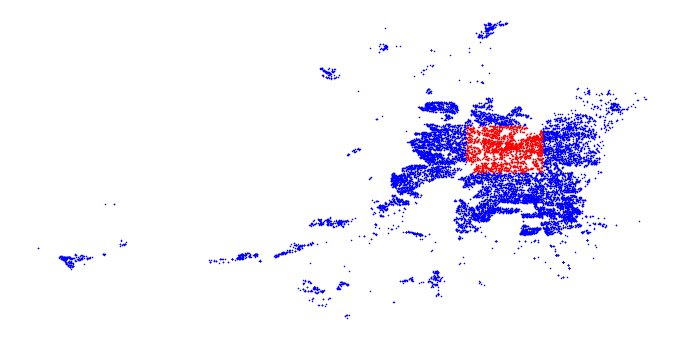

In [0]:
# visualize the distribution of the two sets
plt.figure(figsize=(12,6))
plt.plot(df_train['New_DirCoordX'], df_train['New_DirCoordY'], '*', color='b', markersize=1);
plt.plot(df_test['New_DirCoordX'], df_test['New_DirCoordY'], '*', color='r', markersize=1);
plt.axis("off");

## **Classification**

In [0]:
# split sets into feature and target
cols_to_drop = ["CLASE"]
X_train, y_train = df_train.drop(cols_to_drop, axis=1).values, df_train["CLASE"].values
X_test, y_test = df_test.drop(cols_to_drop, axis=1).values, df_test["CLASE"].values

# scale train set
scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train_scaled = scaler_train.transform(X_train)
X_train_scaled = X_train_scaled

# scale test set
scaler_test = StandardScaler()
scaler_test.fit(X_test)
X_test_scaled = scaler_test.transform(X_test)
X_test_scaled = X_test_scaled

### **Logistic Regression**

In [0]:
# fitting a simple logistic regression
lr = LogisticRegression();
lr.fit(X_train_scaled, y_train);

y_hat = lr.predict(X_test_scaled);
print(classification_report(y_test, y_hat));
print("Accuracy test: {}".format(accuracy_score(y_test, y_hat)));
print("Accuracy train: {}".format(accuracy_score(lr.predict(X_train_scaled), y_train)));

              precision    recall  f1-score   support

           1       0.43      0.66      0.52       639
           2       0.46      0.50      0.48      1152
           3       0.67      0.33      0.44       831

    accuracy                           0.48      2622
   macro avg       0.52      0.49      0.48      2622
weighted avg       0.52      0.48      0.48      2622

Accuracy test: 0.4839816933638444
Accuracy train: 0.5517395182872435


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### **AdaBoost**
The analysis we performed on the data clearly depicts that there is no proper correlation between the targeted column and any feature column. In addition, most of the features are highly correlated which is why we performed a PCA analysis.
We have tried out a lot of different classification methods, from the simplest (e.g. logistic regression in the above section) to sofisticated ones (e.g. XGBoost) and the results were really disapointing. We also performed some grid search on most of the algorithm we have tried in order to get the best results.

However, we decided to use AdaBoost since it is not likely to lead to overfitting and it can be combined to other algorithms to improve accuracy.

In [0]:
# fitting a simple AdaBoostClassifier
clf = AdaBoostClassifier(random_state=42)

clf.fit(X_train_scaled, y_train)

y_hat = clf.predict(X_test_scaled)
print(classification_report(y_test, y_hat))
print("Accuracy test: {}".format(accuracy_score(y_test, y_hat)))
print("Accuracy train: {}".format(accuracy_score(clf.predict(X_train_scaled), y_train)))

              precision    recall  f1-score   support

           1       0.45      0.62      0.52       639
           2       0.49      0.52      0.50      1152
           3       0.62      0.39      0.48       831

    accuracy                           0.50      2622
   macro avg       0.52      0.51      0.50      2622
weighted avg       0.52      0.50      0.50      2622

Accuracy test: 0.5022883295194508
Accuracy train: 0.5630389533154921


We will now perform parameter optimization. The ideal method to perform is an exhaustive grid search. However, since it is really time consuming and did not lead to any significant improvement we will tune the parameters using a validation curve.

We will use simple decision tree as weak learners for our model. 

In [0]:
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", max_depth = 2)

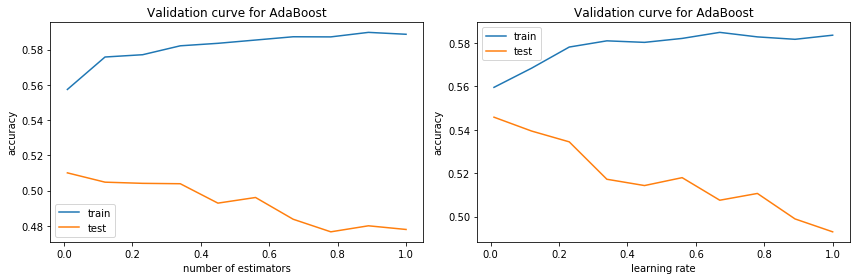

In [0]:
n_estimators_range = np.linspace(10, 100, num=10, dtype=int)
lr_range = np.linspace(.01, 1, num=10)

# validation curve for number of estimators
train_scoreNum, test_scoreNum = validation_curve(
                                AdaBoostClassifier(base_estimator=DTC, random_state=11),
                                X = X_train_scaled, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators_range, cv = 3)

# validation curve for learning rate
train_scoreLr, test_scoreLr = validation_curve(
                                AdaBoostClassifier(base_estimator=DTC, random_state=11),
                                X = X_train_scaled, y = y_train, 
                                param_name = 'learning_rate', 
                                param_range = lr_range, cv = 3)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
ax[0].set_title("Validation curve for AdaBoost");
ax[0].plot(lr_range, np.mean(train_scoreNum, axis=1), label='train');
ax[0].plot(lr_range, np.mean(test_scoreNum, axis=1), label='test');
ax[0].set_xlabel("number of estimators");
ax[0].set_ylabel("accuracy");
ax[0].legend();

ax[1].set_title("Validation curve for AdaBoost");
ax[1].plot(lr_range, np.mean(train_scoreLr, axis=1), label='train');
ax[1].plot(lr_range, np.mean(test_scoreLr, axis=1), label='test');
ax[1].set_xlabel("learning rate");
ax[1].set_ylabel("accuracy");
ax[1].legend();
plt.tight_layout();

In [0]:
# adaboost classifier with best parameters
clf = AdaBoostClassifier(base_estimator=DTC, learning_rate=.01, n_estimators=50, random_state=11)

clf.fit(X_train_scaled, y_train)

y_hat = clf.predict(X_test_scaled)
print(classification_report(y_test, y_hat))
print("Accuracy test: {}".format(accuracy_score(y_test, y_hat)))
print("Accuracy train: {}".format(accuracy_score(clf.predict(X_train_scaled), y_train)))

              precision    recall  f1-score   support

           1       0.49      0.53      0.51       639
           2       0.49      0.62      0.54      1152
           3       0.66      0.37      0.47       831

    accuracy                           0.52      2622
   macro avg       0.54      0.50      0.51      2622
weighted avg       0.54      0.52      0.51      2622

Accuracy test: 0.5160183066361556
Accuracy train: 0.5590246803449301


We can observe a small improvement after parameter tuning. However, the train accuracy is still pretty low, meaning that the model fails at capturing any pattern in the data.

## **Conclusion**
As expected from our preliminary analysis the classification turned out to be quite disappointing. We tried different algorithms in order to capture the underlying information but due to poor quality of the data we were not able to achieve a satisfying performance.